# Ethnicty Classification on Entire Dataset

# Dataset
The given dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. **We will be using all of the 20,000 images**. The dataset in this assignment is going to be used on the following task:

## Given the pixels of an image, perform ethnicity classification for the image using a convolutional neural network.


The dataset for this lab is already cleaned and provided in a CSV format for you with images included as pixel values.

The 4 columns contain the following information:


* **[age]** is an integer from 0 to 116, indicating the age. You can convert it to float for regression predictions
* **[gender]** is either 0 (male) or 1 (female)
* **[race]** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
*  The 4th column contains the pixels of the images flattened to a single dimension. Each of the original image is of size 48x48 and the flattened image vector consists of 48x48 = 2304 pixel values.

In [ ]:
!gdown https://drive.google.com/file/d/1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno
To: /content/DL_assignment1_dataset.csv
100% 199M/199M [00:00<00:00, 228MB/s]


In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Lets use pandas to load our data
df = pandas.read_csv("/content/DL_assignment1_dataset.csv")
df

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...
23700,99,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


### For this assignment we will be using convolutional neural networks and the full data set.

### Please do not change the seed for the sampling of data points.

Let us take a look at an image. You will get an idea of how to process your data for your neural network.

The 4th column contains all the pixel values in a string for each image. Lets convert all the strings to arrays first.

In [ ]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

# normalizing pixels data
df['pixels'] = df['pixels']/255

X = np.array(df['pixels'].tolist())
X = X.reshape(-1,1,48,48)
X.shape

(23705, 1, 48, 48)

In [ ]:
df['pixels']

0        [0.5058824, 0.5019608, 0.5019608, 0.49411765, ...
1        [0.6431373, 0.2901961, 0.43529412, 0.65882355,...
2        [0.2627451, 0.27450982, 0.2784314, 0.27450982,...
3        [0.75686276, 0.77254903, 0.7764706, 0.78431374...
4        [0.7921569, 0.8039216, 0.81960785, 0.8235294, ...
                               ...                        
23700    [0.49803922, 0.39215687, 0.36862746, 0.3176470...
23701    [0.09019608, 0.10980392, 0.1254902, 0.13725491...
23702    [0.23137255, 0.19607843, 0.14509805, 0.1568627...
23703    [0.1764706, 0.42352942, 0.47058824, 0.6117647,...
23704    [0.6117647, 0.6313726, 0.627451, 0.64705884, 0...
Name: pixels, Length: 23705, dtype: object

Our "pixels" column has been converted to arrays which we can now use as input features to our model

Lets show the first image of our dataset

Age: 1
Ethnicity: 2
Gender: 0


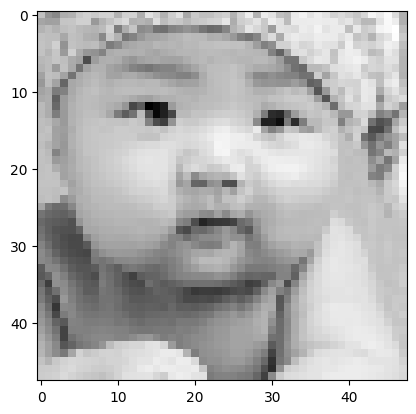

In [ ]:
index = 31
first_image = df['pixels'][index]
image = first_image.reshape((48,48))
print("Age: "+str(df["age"][index])+"\nEthnicity: "+str(df["ethnicity"][index])+ "\nGender: "+str(df["gender"][index]))
plt.imshow(image,cmap="gray")

Uptill now, an initial processing has already been done using pandas in this starter code jupyter notebook. Hence you have a data frame ready for your assignment.

Please use the dataframe "df".

### You should consult the Lab 5 document provided to you for the tasks that are needed to be done for the successful completion of this lab. Grading rubricks are also mentioned in detail there.

# Note: In this lab you will be using all the 20,000 samples of this dataset.



In [ ]:
# Write any further imports you need here
from sklearn.model_selection import train_test_split
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import plotly.figure_factory as ff

Get GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Part 1: Dataset Creation and Data Splitting

###Data Splitting

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
def train_validation_test(dataset, val_size: int = 3555, test_size: int = 3555):
  train_size = len(dataset) - val_size - test_size
  if (test_size == 0 or val_size == 0 ):
    return random_split(dataset, [train_size, (val_size + test_size)])
  else:
    return random_split(dataset, [train_size, val_size, test_size])

###Dataset creation

Converting pixels and wethnicity to numpy array

In [ ]:
X_tensor = torch.from_numpy(X)
y = torch.from_numpy(np.array(df['ethnicity']))
dataset = TensorDataset(X_tensor,y)

Numeric labels for classes

In [ ]:
ethnicity_list=['White', 'Black', 'Asian', 'Indian', 'Others']
dataset.classes = ethnicity_list
print(dataset.classes)

['White', 'Black', 'Asian', 'Indian', 'Others']


Split Dataset and create loader

In [ ]:
# split dataset train/validation/test
train_ds, val_ds, test_ds = train_validation_test(dataset=dataset,val_size=2500,test_size=1000)

batch_size=128
# create batchs using dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

# Building a Unified Neural Network

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

 ### Convolutional Neural Network Architecture

In [ ]:
class EthnicityModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(16),
        nn.Dropout(0.2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
        nn.Dropout(0.2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64),
        nn.Dropout(0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(128),
        nn.Dropout(0.2),

        nn.Flatten(),
        nn.Linear(128 * 1 * 1,128),
        nn.Dropout(0.5),
        nn.Linear(128,256),
        nn.Dropout(0.5),
        nn.Linear(256,5)
    )
  def forward(self, images):
    return self.network(images)

### Training Ethnicity Model

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(EthnicityModel(), device)
model

EthnicityModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()


In [ ]:
def draw_confusion_matrix(class_labels,model, batch_loader):
  nb_classes = len(class_labels)

  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for (images, classes) in batch_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1


  # set up figure
  fig = ff.create_annotated_heatmap(confusion_matrix.tolist(), x=class_labels, y=class_labels, colorscale='Viridis')


  # add custom xaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),
                          x=0.5,
                          y=-0.15,
                          showarrow=False,
                          text="Predicted value",
                          xref="paper",
                          yref="paper"))

  # add custom yaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),
                          x=-0.15,
                          y=0.5,
                          showarrow=False,
                          text="Real value",
                          textangle=-90,
                          xref="paper",
                          yref="paper"))

  # adjust margins to make room for yaxis title
  fig.update_layout(margin=dict(t=50, l=200))

  # add colorbar
  fig['data'][0]['showscale'] = True
  fig.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def get_metrics(batch_loader, model, average_setting = 'binary'):
  preds=[];truth=[]
  with torch.no_grad():
      for (images, classes) in batch_loader:
        outputs = model(images)
        _, pred = torch.max(outputs, dim=1)
        preds = preds + pred.cpu().tolist()
        truth = truth + classes.cpu().tolist()
  print('F1: {}'.format(f1_score(truth, preds,average=average_setting)))
  print('Precision: {}'.format(precision_score(truth, preds, average=average_setting)))
  print('Recall: {}'.format(recall_score(truth, preds, average=average_setting)))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  fig = px.line(x = range(len(accuracies)), y = accuracies, title='Accuracy vs. No. of epochs', labels={'x': 'Epoch', 'y':'Accuracy'},width=800, height=400)
  fig.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = list(range(len(train_losses))), y = train_losses,
                        mode='lines+markers',
                        name='Training'))
    fig.add_trace(go.Scatter(x = list(range(len(val_losses))), y = val_losses,
                        mode='lines+markers',
                        name='Validation'))
    fig.update_layout(title='Loss vs. No. of epochs',
                   xaxis_title='Epoch',
                   yaxis_title='Loss', width=800, height=400)
    fig.show()

# Helper function which returns the predicted label for a single image tensor
def predict_label(img, model, label_classes):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label
  if label_classes:
    return label_classes[preds[0].item()]
  else:
    return preds[0].item()

In [ ]:
history = evaluate(model, val_dl)
print("Untrained Accuracy: ", history['val_acc'])
print("Untrained Loss: ", history['val_loss'])

Untrained Accuracy:  0.15888074040412903
Untrained Loss:  1.6238206624984741


In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2013, val_loss: 0.9135, val_acc: 0.6528
Epoch [1], train_loss: 0.9291, val_loss: 0.8336, val_acc: 0.6982
Epoch [2], train_loss: 0.8521, val_loss: 0.7947, val_acc: 0.7136
Epoch [3], train_loss: 0.8031, val_loss: 0.8549, val_acc: 0.6789
Epoch [4], train_loss: 0.7718, val_loss: 0.6810, val_acc: 0.7575
Epoch [5], train_loss: 0.7407, val_loss: 0.6802, val_acc: 0.7638
Epoch [6], train_loss: 0.7179, val_loss: 0.6831, val_acc: 0.7547
Epoch [7], train_loss: 0.7061, val_loss: 0.6374, val_acc: 0.7796
Epoch [8], train_loss: 0.6888, val_loss: 0.6426, val_acc: 0.7697
Epoch [9], train_loss: 0.6735, val_loss: 0.6129, val_acc: 0.7814
Epoch [10], train_loss: 0.6613, val_loss: 0.6961, val_acc: 0.7543
Epoch [11], train_loss: 0.6476, val_loss: 0.6511, val_acc: 0.7729
Epoch [12], train_loss: 0.6468, val_loss: 0.6051, val_acc: 0.7838
Epoch [13], train_loss: 0.6209, val_loss: 0.6378, val_acc: 0.7748
Epoch [14], train_loss: 0.6130, val_loss: 0.5855, val_acc: 0.7983
Epoch [15], train_lo

### Performance Monitoring


Plot of Accuracy Vs Epochs

In [ ]:
plot_accuracies(history)

Plot of Loss Vs Epochs

In [ ]:
plot_losses(history)

In [ ]:
get_metrics(train_dl,model, average_setting='weighted')

F1: 0.8134138089280489
Precision: 0.8399705240555043
Recall: 0.8336055431823806


Performance on test data

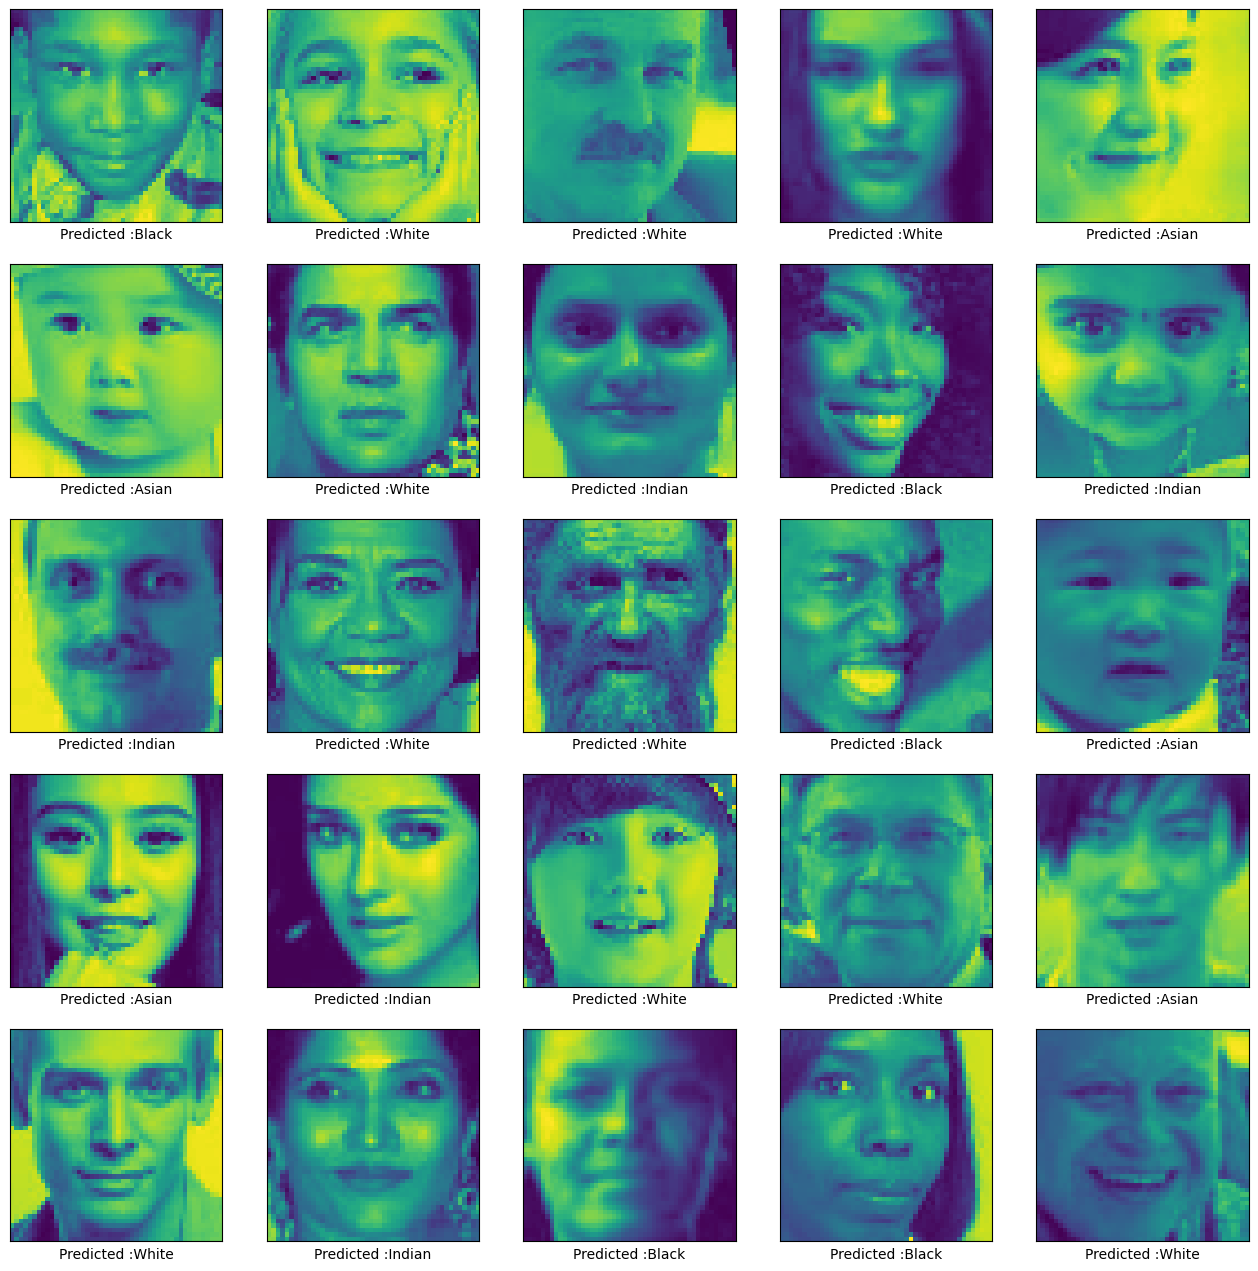

In [ ]:
index=np.random.randint(0,712,25) # predicted label and their images

plt.figure(figsize=(16,16))

for i in range(len(index)):
    plt.subplot(5,5,(i%25)+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_ds[index[i]][0].squeeze())
    plt.xlabel("Predicted :" + predict_label(test_ds[index[i]][0],model,dataset.classes)
    )

plt.show()

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_dl)
print("Test Accuracy: ",result['val_acc'])
print("Test Loss: ",result['val_loss'])
get_metrics(test_dl,model,'weighted')

Test Accuracy:  0.7660291194915771
Test Loss:  0.7347647547721863
F1: 0.7358484379290671
Precision: 0.7553809572440088
Recall: 0.766


In [ ]:
draw_confusion_matrix(ethnicity_list,model,test_dl)